# GVB Visualization

## Imports

In [2]:
import pandas as pd
import datetime

#Visualizations
import matplotlib.pyplot as plt
import descartes
import geopandas as gpd
from shapely.geometry import Point, Polygon

%matplotlib inline

## Import Files

In [13]:
#Full GVB Dataset
gvb_df = pd.read_csv("../../../Data_thesis/Full_Datasets/GVB.csv")

In [4]:
#Map to plot points on
road_map = gpd.read_file("../../../Data_thesis/MapShapeFiles/roads.shp")

## Plot Stations on Map

In [14]:
gvb_df.head()

,Date,Hour,NieuwmarktCode,NieuwmarktLat,NieuwmarktLon,NieuwmarktArrivals,NieuwmarktDepartures,NieuwezijdsCode,NieuwezijdsLat,NieuwezijdsLon,...,DamLon,DamArrivals,DamDepartures,SpuiCode,SpuiLat,SpuiLon,SpuiArrivals,SpuiDepartures,weekday,is_weekend
0,2018-01-01,100,NMT,52.371942,4.901239,11.0,340.0,5069,52.376288,4.893731,...,4.89008,0.0,0.0,5062,52.369097,4.889259,0.0,0.0,0,0
1,2018-01-01,200,NMT,52.371942,4.901239,48.0,175.0,5069,52.376288,4.893731,...,4.89008,21.0,39.0,5062,52.369097,4.889259,0.0,0.0,0,0
2,2018-01-01,300,NMT,52.371942,4.901239,10.0,137.0,5069,52.376288,4.893731,...,4.89008,13.0,48.0,5062,52.369097,4.889259,0.0,0.0,0,0
3,2018-01-01,400,NMT,52.371942,4.901239,16.0,48.0,5069,52.376288,4.893731,...,4.89008,0.0,34.0,5062,52.369097,4.889259,0.0,0.0,0,0
4,2018-01-01,500,NMT,52.371942,4.901239,17.0,56.0,5069,52.376288,4.893731,...,4.89008,0.0,20.0,5062,52.369097,4.889259,0.0,0.0,0,0


### Variables

In [33]:
#Coordinate system
crs = {"init": "epsg:4326"}

#Dict to save coordinates in
station_cor_dict = {}

### Construct Df

In [34]:
gvb_dict = gvb_df.to_dict("index")

station_cor_dict["Nieuwmarkt"] = {"Latitude": gvb_dict[0]["NieuwmarktLat"], "Longitude": gvb_dict[0]["NieuwmarktLon"]}
station_cor_dict["Nieuwezijdse Kolk"] = {"Latitude": gvb_dict[0]["NieuwezijdsLat"], 
                                         "Longitude": gvb_dict[0]["NieuwezijdsLon"]}
station_cor_dict["Dam"] = {"Latitude": gvb_dict[0]["DamLat"], "Longitude": gvb_dict[0]["DamLon"]}
station_cor_dict["Spui"] = {"Latitude": gvb_dict[0]["SpuiLat"], "Longitude": gvb_dict[0]["SpuiLon"]}

station_cor_df = pd.DataFrame.from_dict(station_cor_dict, orient="index").reset_index()
station_cor_df = station_cor_df.rename(index=str, columns={"index": "Station"})

In [35]:
station_cor_df.head()

,Station,Latitude,Longitude
0,Dam,52.373127,4.890080
1,Nieuwezijdse Kolk,52.376288,4.893731
2,Nieuwmarkt,52.371942,4.901239
3,Spui,52.369097,4.889259


In [36]:
#Create a point object -> Point is essentially a single object that describes the longitude and latitude of a data-point
geometry = [Point(xy) for xy in zip(station_cor_df["Longitude"], station_cor_df["Latitude"])]

gvb_geo_df = gpd.GeoDataFrame(station_cor_df,
                         crs = crs,
                         geometry = geometry)

gvb_geo_df = gvb_geo_df[["Station", "geometry"]]

In [37]:
gvb_geo_df.head()

,Station,geometry
0,Dam,POINT (4.89008027 52.37312668)
1,Nieuwezijdse Kolk,POINT (4.89373093 52.37628765)
2,Nieuwmarkt,POINT (4.90123885 52.37194169)
3,Spui,POINT (4.88925912 52.36909673)


### Map

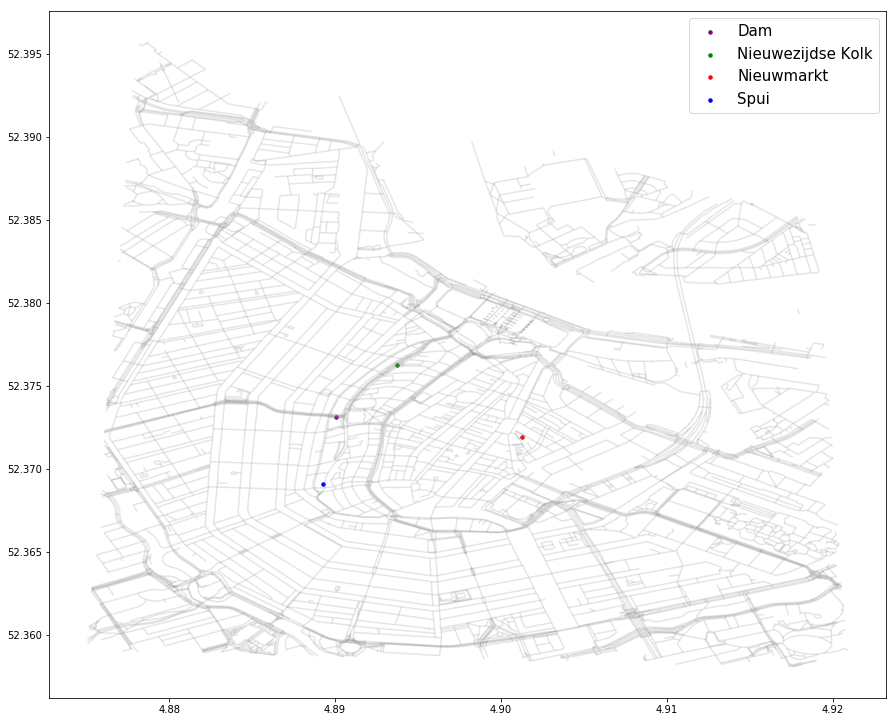

In [40]:
fig,ax = plt.subplots(figsize = (15, 15))
road_map.plot(ax = ax, alpha = 0.2, color = "grey")
gvb_geo_df[gvb_geo_df["Station"] == "Dam"].plot(ax = ax, markersize = 12, color = "purple", marker = "o", 
                                                        label = "Dam")
gvb_geo_df[gvb_geo_df["Station"] == "Nieuwezijdse Kolk"].plot(ax = ax, markersize = 12, color = "green", marker = "o", 
                                                        label = "Nieuwezijdse Kolk")
gvb_geo_df[gvb_geo_df["Station"] == "Nieuwmarkt"].plot(ax = ax, markersize = 12, color = "red", marker = "o", 
                                                        label = "Nieuwmarkt")
gvb_geo_df[gvb_geo_df["Station"] == "Spui"].plot(ax = ax, markersize = 12, color = "blue", marker = "o", 
                                                        label = "Spui")
plt.legend(prop={"size": 15})

## Plot Crowdedness counts per station

### Variables

In [42]:
#Nieuwmarkt
niew_arr = {}
niew_dep = {}

#Nieuwezijds
nwz_arr = {}
nwz_dep = {}

#Dam
dam_arr = {}
dam_dep = {}

#Spui
spui_arr = {}
spui_dep = {}

### Construct Dict

In [54]:
gvb_dict = gvb_df.to_dict("index")

for k, v in gvb_dict.items():
    
    #Combine date and time
    t = int(v["Hour"]/100)
    v["Date"] = pd.Timestamp.strptime(v["Date"], "%Y-%m-%d")
    d = datetime.datetime.combine(v["Date"], datetime.time(t,0))
    
    #Nieuwmarkt
    niew_arr[d] = v["NieuwmarktArrivals"]
    niew_dep[d] = v["NieuwmarktDepartures"]
    
    #Nieuwezijds
    nwz_arr[d] = v["NieuwezijdsArrivals"]
    nwz_dep[d] = v["NieuwezijdsDepartures"]
    
    #Dam
    dam_arr[d] = v["DamArrivals"]
    dam_dep[d] = v["DamDepartures"]
    
    #Spui
    spui_arr[d] = v["SpuiArrivals"]
    spui_dep[d] = v["SpuiDepartures"]
    
#Nieuwmarkt
niew_arr_series = pd.Series(niew_arr)
niew_dep_series = pd.Series(niew_dep)

#Nieuwezijds
nwz_arr_series = pd.Series(nwz_arr)
nwz_dep_series = pd.Series(nwz_dep)

#Dam
dam_arr_series = pd.Series(dam_arr)
dam_dep_series = pd.Series(dam_dep)

#Spui
spui_arr_series = pd.Series(spui_arr)
spui_dep_series = pd.Series(spui_dep)

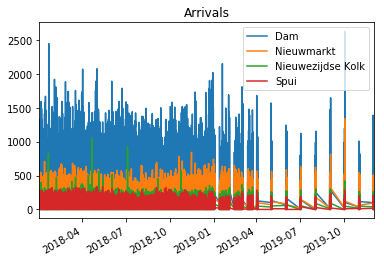

In [70]:
dam_arr_series.plot(legend=True, title='Arrivals', label="Dam")
niew_arr_series.plot(legend=True, label="Nieuwmarkt")
nwz_arr_series.plot(legend=True, label="Nieuwezijdse Kolk")
spui_arr_series.plot(legend=True, label="Spui")
plt.show()

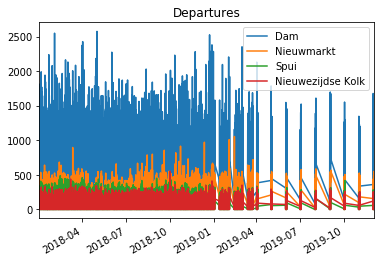

In [76]:
dam_dep_series.plot(legend=True, title='Departures', label="Dam")
niew_dep_series.plot(legend=True, label="Nieuwmarkt")
spui_dep_series.plot(legend=True, label="Spui")
nwz_dep_series.plot(legend=True, label="Nieuwezijdse Kolk")
plt.show()